# Import Section

In [1]:
from audapter.driver.filter_driver import FilterDriver

In [2]:
import numpy as np
from scipy.fft import rfft, irfft, rfftfreq, fft, ifft, fftfreq
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nptyping import Array

## import Virtual Error Source

In [41]:
from pysndfx import AudioEffectsChain

SOUND_FIELD = lambda x: x.copy()
# AEC = AudioEffectsChain()
# SOUND_FIELD = AEC.overdrive()

## import Warning Controller

In [42]:
from warnings import simplefilter
simplefilter('ignore')

# Define Global Variables

In [43]:
# Period
T_msec = 100

# Sample rate
fs = 44100
nyquist = fs//2

# Data size
N = fs * T_msec // 1000

# Filter Length
w_len = 10

# Maximum Amplifier
A_max = 256

# Amplifier
A = .8 * A_max

# Frequency of sound
w_sound = 440.

# Time
END_OF_TIME = 20
t = np.linspace(0, END_OF_TIME, fs*END_OF_TIME, dtype=np.float64)

## Make Arrays for Caching

In [44]:
x_cache = A * np.sin(w_sound * (2 * np.pi * t))

d_cache = x_cache[:]

y_cache = np.zeros_like(t)

f_cache = np.zeros_like(y_cache)

w_cache = np.zeros((END_OF_TIME*1000//T_msec, w_len), dtype=np.float64)

# Main Section

## in First Step

In [45]:
## START_OF_THREAD ##
x_now = x_cache[: N]
# Output(FOR sound-field, FOR NOW, pass thru)
y_now = x_now.copy()
f_now = SOUND_FIELD(y_now[:])
# Caching
y_cache[: N] = y_now[:]
f_cache[: N] = f_now[:]

## DOMAIN: TIME

In [46]:
# # Filter
# driver = FilterDriver(shape=w_len)

# w_cache[0] = driver.get_filter_weights()[:]

# for i in range(1, END_OF_TIME * 1000//T_msec):
    
#     ## START_OF_THREAD ##
    
#     # Desired signal IN PREV
#     d = d_cache[(i-1)*N  : i*N - w_len]
    
#     # Make input-array from 'f'
#     f_indata = np.array([f_cache[(i-1)*N+n : (i-1)*N+n + w_len] for n in range(N - w_len)])
    
#     # Filter weight matrix(in time)
#     w_new = driver.tune(desired=d, data_in=f_indata)
    
#     # Caching
#     w_cache[i] = w_new[:]
    
    
#     ## START_OF_THREAD ##
    
#     # Make input-array from 'x'
#     x_indata = np.array([x_cache[i*N+n : i*N+n + w_len] for n in range(N - w_len)])
    
#     # Get filter IN PREV
#     w_old = w_cache[(i-1)].reshape(1, -1)
    
#     # Output(FOR sound-field, FOR NOW)
#     y_now = np.dot(w_old, x_indata.T[::-1])
#     f_now = SOUND_FIELD(y_now[:]).reshape(1, -1)
#     # Caching
#     y_cache[i*N + w_len : (i+1)*N] = y_now[:]
#     f_cache[i*N + w_len : (i+1)*N] = f_now[:]

## DOMAIN: FREQ

In [47]:
# splitting rate
split_num = 100

# STEP_SIZE = 1[sec]
# FRAGMENT_SIZE
N = fs

# Frequency in freq. domain
omega = rfftfreq(N, d=1./fs)

# Filter
DRIVERS = [FilterDriver(shape=w_len) for _ in range(omega.size//split_num+1)]

# Make array for caching FILTER_WEIGHTS
W_CACHE = np.zeros((END_OF_TIME, omega.size//split_num+1, w_len), dtype=np.float64)

for i in range(1, END_OF_TIME):
    ## START_OF_THREAD ##

    # Desired signal IN PREV
    d = np.array([d_cache[(i-1)*N + n*split_num : (i-1)*N + (n+1)*split_num] for n in range(N//split_num)])
    if i == 1:
        print(d.shape)

    # Make input-array from 'f'
    f = np.array([f_cache[(i-1)*N + n*split_num : (i-1)*N + (n+1)*split_num] for n in range(N//split_num)])
    if i == 1:
        print(f.shape)

    # FFT
    D = np.abs(rfft(d, axis=0)) / N/split_num
    F = rfft(f, axis=0) / N/split_num
    if i == 1:
        print(D.shape)

    # Make input-array from 'F'
    F_IN = np.array([F[:, n : n+w_len] for n in range(split_num - w_len)])[::-1]
    if i == 1:
        print(F_IN.shape)

    # Filter weight matrix(IN FREQ)
    W_NEW = np.array([driver.tune(desired=D[w, -(split_num-w_len):], data_in=F_IN[:, w]) for w, driver in enumerate(DRIVERS)])
    if i == 1:
        print(W_NEW.shape)

    # Caching
    W_CACHE[i] = W_NEW[:]


    ## START_OF_THREAD ##

    # Input signal FOR NOW
    x = np.array([x_cache[i*N + n*split_num : i*N + (n+1)*split_num] for n in range(N//split_num)])

    # FFT
    X = rfft(x, axis=0) / N/split_num
    # Make input-array from 'X'
    X_IN = np.array([X[:, n : n+w_len] for n in range(split_num - w_len)])[::-1]

    # Get filter IN PREV
    W_OLD = W_CACHE[i-1]

    # Output(FOR sound-field, FOR NOW)
    Y_NOW = np.array([np.dot(W_OLD[w], X_IN[:, w].T) for w in range(X_IN.shape[1])])
    if i == 1:
        print(Y_NOW.shape)
    
    y_now = irfft(Y_NOW, axis=0).reshape(-1)
    if i == 1:
        print(y_now.shape)
    f_now = SOUND_FIELD(y_now[:]).astype(np.float64)
    # Caching
    y_cache[(i+1)*N - len(y_now) : (i+1)*N] = y_now[:]
    f_cache[(i+1)*N - len(f_now) : (i+1)*N] = f_now[:]

(441, 100)
(441, 100)
(221, 100)
(90, 221, 10)
(221, 10)
(221, 90)
(39600,)


# Plot Result

In [48]:
tail = t.size

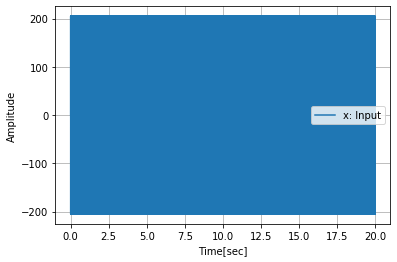

In [49]:
plt.plot(t[-tail:], x_cache[-tail:], label="x: Input")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

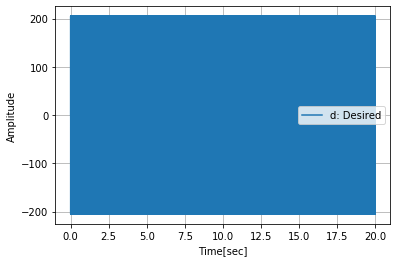

In [50]:
plt.plot(t[-tail:], d_cache[-tail:], label="d: Desired")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

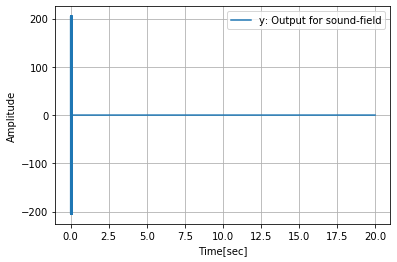

In [51]:
plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

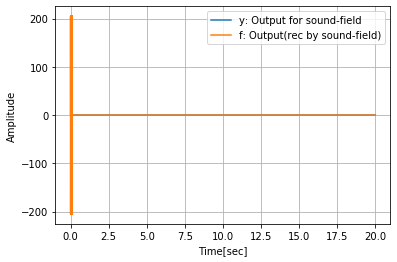

In [52]:
plt.plot(t[-tail:], y_cache[-tail:], label="y: Output for sound-field")
plt.plot(t[-tail:], f_cache[-tail:], label="f: Output(rec by sound-field)")
plt.xlabel("Time[sec]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

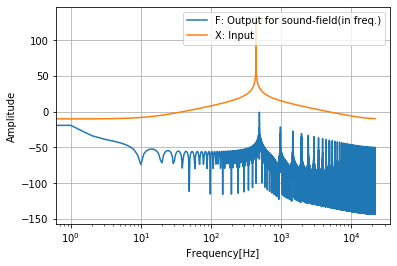

In [53]:
plt.plot(omega, 20*np.log10(rfft(f_cache[-N:])), label="F: Output for sound-field(in freq.)")
plt.plot(omega, 20*np.log10(rfft(x_cache[-N:])), label="X: Input")
plt.xlabel("Frequency[Hz]")
plt.ylabel("Amplitude")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

In [54]:
from plotly import graph_objects as go

In [36]:
fig = go.Figure(data=[go.Surface(x=omega, y=np.arange(END_OF_TIME), z=W_CACHE)])
fig.show()